In [1]:
import os  # For interacting with the file system (creating directories, listing files, etc.)
import shutil  # For copying files from one folder to another
import random  # For shuffling file lists randomly

# Step 1: Define dataset directory paths
dataset_dir = "Data_sets"  # Main dataset directory containing images
train_dir = os.path.join(dataset_dir, "train")  # Directory for training images
test_dir = os.path.join(dataset_dir, "test")  # Directory for testing images

for folder in ["train", "test"]:  
    os.makedirs(os.path.join(train_dir, "male"), exist_ok=True)
    os.makedirs(os.path.join(train_dir, "female"), exist_ok=True)
    os.makedirs(os.path.join(test_dir, "male"), exist_ok=True)
    os.makedirs(os.path.join(test_dir, "female"), exist_ok=True)

# Step 3: Function to split the dataset into training and testing sets
def split_data(source, train_dest, test_dest, split_size=0.2):


    files = os.listdir(source)  # List all files in the directory
    files = [f for f in files if f.endswith(".jpg") or f.endswith(".png")]  # Filter only image files

    random.shuffle(files)  # Shuffle the list for randomness

    split_point = int(len(files) * split_size)  # Calculate the split index based on percentage
    test_files = files[:split_point]  # First part goes to test set
    train_files = files[split_point:]  # Remaining part goes to train set

    for f in train_files:
        shutil.copy(os.path.join(source, f), train_dest)  # Copy each file to the train directory

    for f in test_files:
        shutil.copy(os.path.join(source, f), test_dest)  # Copy each file to the test directory


split_data(os.path.join(dataset_dir, "male"), os.path.join(train_dir, "male"), os.path.join(test_dir, "male"))
split_data(os.path.join(dataset_dir, "female"), os.path.join(train_dir, "female"), os.path.join(test_dir, "female"))

# Step 5: Print success message
print("Dataset successfully split into training and testing sets!")


Dataset successfully split into training and testing sets!


## Testing some samples of the classification

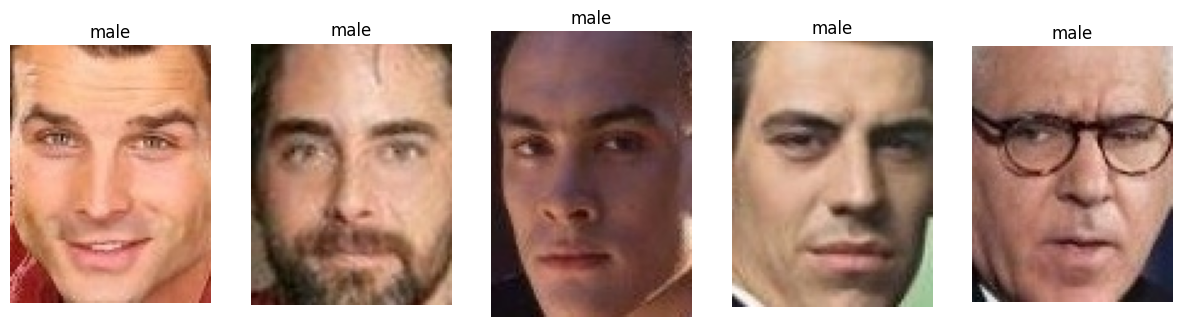

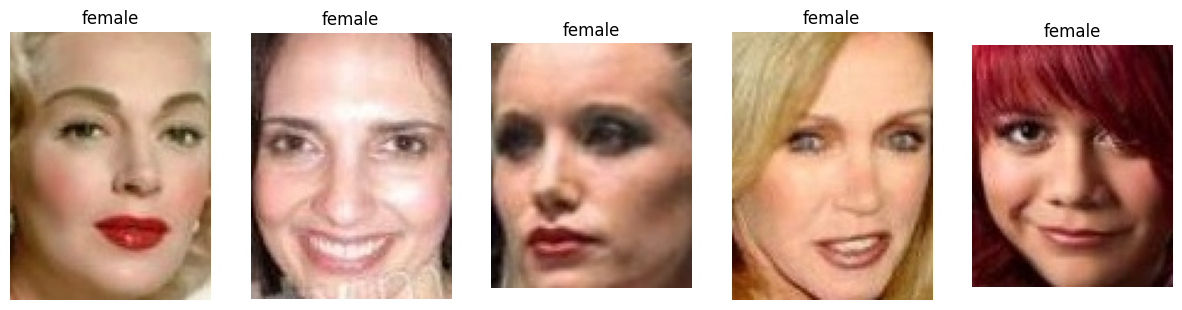

In [2]:
import cv2
import matplotlib.pyplot as plt

train_dir = './Data_Sets/train'

def display_samples(category,num_samples = 5):
    folder= os.path.join(train_dir,category)
    images = random.sample(os.listdir(folder),num_samples)
    
    fig,ax = plt.subplots(1,num_samples,figsize=(15,5))
    for i,img_name in enumerate(images):
        img=cv2.imread(os.path.join(folder,img_name))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(category)
        
    plt.show()
    
display_samples("male")
display_samples("female")

## Preprocessing the data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode = 'binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode ='binary'
)

print("Data Preprocessing Complete! Ready for Training")

Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.
Data Preprocessing Complete! Ready for Training


## Generating the model summary

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Load the VGG16 model without the top classification layers.
# The VGG16 model is pre-trained on the ImageNet dataset, and we exclude the top fully connected layers.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 2. Freeze the convolutional layers to retain their pre-trained weights.
# By freezing the layers, we ensure that the pre-trained features (like edge detection, textures, etc.) remain unchanged.
# We only want to train the custom classifier on top, not the VGG16 layers themselves.
for layer in base_model.layers:
    layer.trainable = False

# 3. Add custom layers on top for binary classification (Cat vs Dog).
# We are adding a classifier specifically for our task of distinguishing between cats and dogs.

# Flatten the feature maps output by the VGG16 base model.
# The base model outputs feature maps (multi-dimensional arrays), but we need to flatten them into a single vector.
x = Flatten()(base_model.output)

# Add a fully connected layer with 128 units and ReLU activation.
# This layer helps learn non-linear combinations of the features extracted by VGG16.
x = Dense(128, activation='relu')(x)

# Add a Dropout layer to prevent overfitting.
# Dropout helps prevent overfitting by randomly setting a fraction of the input units to zero during training.
# This forces the model to generalize better and not rely too much on any one feature.
x = Dropout(0.5)(x)

# Add the final output layer with 1 unit and sigmoid activation for binary classification.
# The sigmoid activation outputs a probability between 0 and 1, which represents the likelihood that the image is a "dog".
# Since we have binary classification (Cat vs Dog), we only need 1 output unit.
output = Dense(1, activation='sigmoid')(x)

# 4. Create the complete model by specifying the inputs and outputs.
# The inputs of the model are from the base VGG16 model, and the outputs are the result of our custom classifier (output).
model = Model(inputs=base_model.input, outputs=output)

# 5. Compile the model.
# We use the Adam optimizer with a learning rate of 0.0001. Adam is an adaptive learning rate optimizer.
# The loss function is binary cross-entropy, which is commonly used for binary classification tasks (like Cat vs Dog).
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

## Training and saving the trained model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential([
    #First Convolutional Blockk
    Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    #Second Convolutional Blockk
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    #Third Convolutional Blockk
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    
    #Flatten and Fully Connected Layers
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.5), # Prevent Overfitting
    Dense(64,activation='relu'),
    Dense(1,activation='sigmoid')
    
])

#Comple the Model
model.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [6]:
# Train the Model

history = model.fit(
    train_data,
    epochs=20,
    validation_data = test_data,
    batch_size=32
)
# Save the trained model in the 'ML_MODEL' Directory
model_dir = 'ML_MODEL'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model_path = os.path.join(model_dir,'Men_Women_model_from_scratch.h5')
model.save(model_path)
print(f"Model has been saved at {model_path}")

Epoch 1/20
1176/1176 [==============================] - 746s 633ms/step - loss: 0.5345 - accuracy: 0.7252 - val_loss: 0.3159 - val_accuracy: 0.8715
Epoch 2/20
1176/1176 [==============================] - 350s 297ms/step - loss: 0.3713 - accuracy: 0.8475 - val_loss: 0.2549 - val_accuracy: 0.8985
Epoch 3/20
1176/1176 [==============================] - 349s 297ms/step - loss: 0.3150 - accuracy: 0.8729 - val_loss: 0.2094 - val_accuracy: 0.9215
Epoch 4/20
1176/1176 [==============================] - 344s 292ms/step - loss: 0.2815 - accuracy: 0.8907 - val_loss: 0.1878 - val_accuracy: 0.9323
Epoch 5/20
1176/1176 [==============================] - 346s 294ms/step - loss: 0.2500 - accuracy: 0.9046 - val_loss: 0.1842 - val_accuracy: 0.9283
Epoch 6/20
1176/1176 [==============================] - 345s 293ms/step - loss: 0.2271 - accuracy: 0.9138 - val_loss: 0.1569 - val_accuracy: 0.9449
Epoch 7/20
1176/1176 [==============================] - 343s 292ms/step - loss: 0.2079 - accuracy: 0.9215 - val_

## Refining the Model to Improve accuracy

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Load the VGG16 model without the top classification layers.
# The VGG16 model is pre-trained on the ImageNet dataset, and we exclude the top fully connected layers.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 2. Freeze the convolutional layers to retain their pre-trained weights.
# By freezing the layers, we ensure that the pre-trained features (like edge detection, textures, etc.) remain unchanged.
# We only want to train the custom classifier on top, not the VGG16 layers themselves.
for layer in base_model.layers:
    layer.trainable = False

# 3. Add custom layers on top for binary classification (Cat vs Dog).
# We are adding a classifier specifically for our task of distinguishing between cats and dogs.

# Flatten the feature maps output by the VGG16 base model.
# The base model outputs feature maps (multi-dimensional arrays), but we need to flatten them into a single vector.
x = Flatten()(base_model.output)

# Add a fully connected layer with 128 units and ReLU activation.
# This layer helps learn non-linear combinations of the features extracted by VGG16.
x = Dense(128, activation='relu')(x)

# Add a Dropout layer to prevent overfitting.
# Dropout helps prevent overfitting by randomly setting a fraction of the input units to zero during training.
# This forces the model to generalize better and not rely too much on any one feature.
x = Dropout(0.5)(x)

# Add the final output layer with 1 unit and sigmoid activation for binary classification.
# The sigmoid activation outputs a probability between 0 and 1, which represents the likelihood that the image is a "dog".
# Since we have binary classification (Cat vs Dog), we only need 1 output unit.
output = Dense(1, activation='sigmoid')(x)

# 4. Create the complete model by specifying the inputs and outputs.
# The inputs of the model are from the base VGG16 model, and the outputs are the result of our custom classifier (output).
model = Model(inputs=base_model.input, outputs=output)

# 5. Compile the model.
# We use the Adam optimizer with a learning rate of 0.0001. Adam is an adaptive learning rate optimizer.
# The loss function is binary cross-entropy, which is commonly used for binary classification tasks (like Cat vs Dog).
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary.
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [10]:
#Train the model (only the newly added layers)

history= model.fit(
    train_data, # Training data (already augmented)
    epochs=10, # Number of epochs for training
    validation_data=test_data, # Validation data
    batch_size=32# Batch size for training
)

# Save the trained model in the 'ML_MODEL' Directory
model_dir = 'ML_MODEL'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model_path = os.path.join(model_dir,'Men_Women_finetuned_model_from_scratch.h5')
model.save(model_path)

Epoch 1/10
1176/1176 [==============================] - 352s 299ms/step - loss: 0.1397 - accuracy: 0.9490 - val_loss: 0.1152 - val_accuracy: 0.9595
Epoch 2/10
1176/1176 [==============================] - 350s 297ms/step - loss: 0.1354 - accuracy: 0.9514 - val_loss: 0.1129 - val_accuracy: 0.9601
Epoch 3/10
1176/1176 [==============================] - 346s 294ms/step - loss: 0.1339 - accuracy: 0.9506 - val_loss: 0.1094 - val_accuracy: 0.9629
Epoch 4/10
1176/1176 [==============================] - 347s 295ms/step - loss: 0.1342 - accuracy: 0.9508 - val_loss: 0.1128 - val_accuracy: 0.9604
Epoch 5/10
1176/1176 [==============================] - 351s 298ms/step - loss: 0.1292 - accuracy: 0.9539 - val_loss: 0.1078 - val_accuracy: 0.9625
Epoch 6/10
1176/1176 [==============================] - 366s 311ms/step - loss: 0.1283 - accuracy: 0.9542 - val_loss: 0.1087 - val_accuracy: 0.9627
Epoch 7/10
1176/1176 [==============================] - 347s 295ms/step - loss: 0.1267 - accuracy: 0.9545 - val_

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model('ML_MODEL/Men_Women_model_from_scratch.h5')

img_path = "Data_sets/test/female/202519.jpg.jpg"
img = image.load_img(img_path,target_size = (128,128))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array,axis=0)

#make a prediction
prediction = model.predict(img_array)
if prediction >= 0.5:
    print('Its a Man')
else:
    print('Its a female')

1/1 [==============================] - 0s 115ms/step
Its a female
